In [48]:
import os
import networkx as nx
import re
import matplotlib.pyplot as plt
from fa2_modified import ForceAtlas2
import pickle

### First approach - Papers as nodes and same authors as edges

In [2]:
def create_paper_network(directory="papers/ai"):
    # Initialize a graph
    graph = nx.Graph()

    # Read metadata files
    for file_name in os.listdir(directory):
        if file_name.endswith("_metadata.txt"):
            file_path = os.path.join(directory, file_name)
            
            with open(file_path, "r", encoding="utf-8") as f:
                content = f.read()

            # Extract metadata from file
            title = re.search(r"Title: (.+)", content).group(1)
            published_date = re.search(r"Published Date: (.+)", content).group(1)
            authors = re.search(r"Authors: (.+)", content).group(1)

            # Extract year from published_date
            year = published_date.split("-")[0]

            # Clean authors
            author_list = [author.strip() for author in authors.split(",")]

            # Add node with features
            graph.add_node(title, publishing_year=year, authors=author_list)

    # Create edges based on shared authors
    nodes = list(graph.nodes(data=True))
    for i in range(len(nodes)):
        title1, data1 = nodes[i]
        authors1 = set(data1["authors"])

        for j in range(i + 1, len(nodes)):
            title2, data2 = nodes[j]
            authors2 = set(data2["authors"])

            # Check for shared authors
            if authors1 & authors2:
                graph.add_edge(title1, title2)

    return graph

In [ ]:
# Generate and save the graph
graph = create_paper_network()

In [55]:
print(f'Number of nodes is: {len(graph.nodes())}')

Number of nodes is: 13993


In [56]:
print(f'Number of edges is: {len(graph.edges())}')

Number of edges is: 43117


In [ ]:
graph.nodes['Canonical momenta indicators of financial markets and neocortical EEG']

{'publishing_year': '2000', 'authors': ['Lester Ingber']}

#### Plot degree

In [ ]:
def plot_degree_distribution(graph):
    """
    Computes and plots the degree distribution of the given graph.

    Parameters:
        graph (networkx.Graph): The input graph.
    """
    # Get the degree of each node
    degrees = [d for _, d in graph.degree()]
    
    # Count the frequency of each degree
    degree_counts = {}
    for degree in degrees:
        if degree in degree_counts:
            degree_counts[degree] += 1
        else:
            degree_counts[degree] = 1
    
    # Prepare data for plotting
    degrees = list(degree_counts.keys())
    counts = list(degree_counts.values())

    # Plot the degree distribution
    plt.figure(figsize=(10, 6))
    plt.scatter(degrees, counts, color="blue", alpha=0.7, s=50, label="Degree Count")
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Degree Distribution (Log-Log Scale)", fontsize=14)
    plt.xlabel("Degree (log scale)", fontsize=12)
    plt.ylabel("Number of Nodes (log scale)", fontsize=12)
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

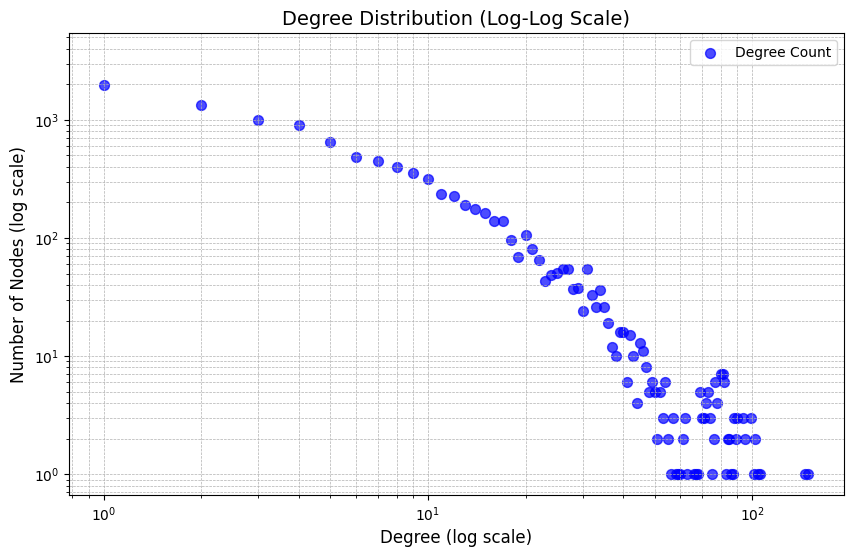

In [25]:
# Example usage
plot_degree_distribution(graph)

### Second approach - Researchers as nodes and same paper as edges

In [9]:
def build_researcher_graph(directory="papers/ai"):
    """
    Builds a co-authorship graph where nodes are researchers and edges are weighted
    by the number of papers co-authored.

    Parameters:
        directory (str): Path to the directory containing metadata files.

    Returns:
        networkx.Graph: The co-authorship graph.
    """
    # Initialize a graph
    graph = nx.Graph()

    # Read metadata files
    for file_name in os.listdir(directory):
        if file_name.endswith("_metadata.txt"):
            file_path = os.path.join(directory, file_name)
            
            with open(file_path, "r", encoding="utf-8") as f:
                content = f.read()

            # Extract authors
            authors = re.search(r"Authors: (.+)", content).group(1)
            author_list = [author.strip() for author in authors.split(",")]

            # Add edges for each pair of co-authors
            for i in range(len(author_list)):
                for j in range(i + 1, len(author_list)):
                    author1 = author_list[i]
                    author2 = author_list[j]

                    if graph.has_edge(author1, author2):
                        graph[author1][author2]["weight"] += 1
                    else:
                        graph.add_edge(author1, author2, weight=1)

    return graph

In [10]:
researcher_graph = build_researcher_graph()

In [53]:
print(f'Number of nodes is: {len(researcher_graph.nodes())}')

Number of nodes is: 47399


In [54]:
print(f'Number of edges is: {len(researcher_graph.edges())}')

Number of edges is: 303627


#### Save and load graph

In [49]:
with open('researchers_graph', "wb") as f:
    pickle.dump(researcher_graph, f)

In [50]:
with open('researchers_graph', "rb") as f:
    loaded_graph = pickle.load(f)

#### Plot degree

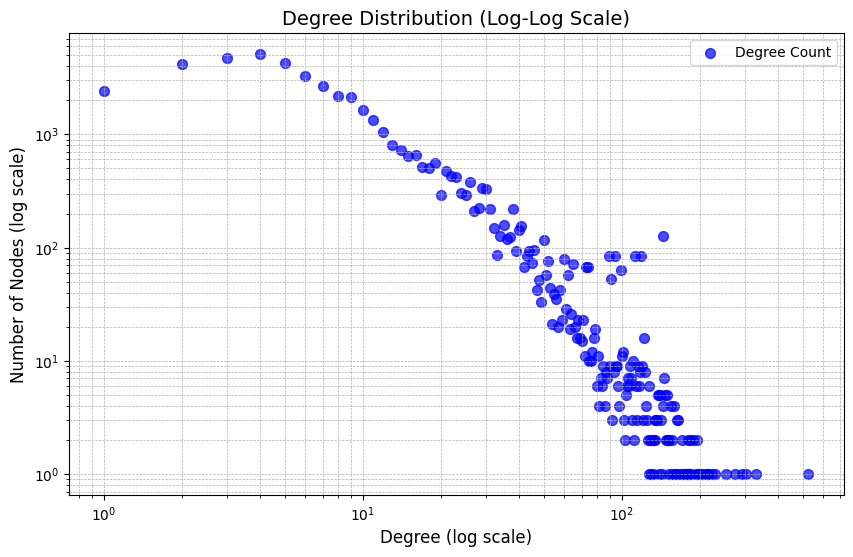

In [ ]:
# Example usage
plot_degree_distribution(researcher_graph)

#### Quick weights plot

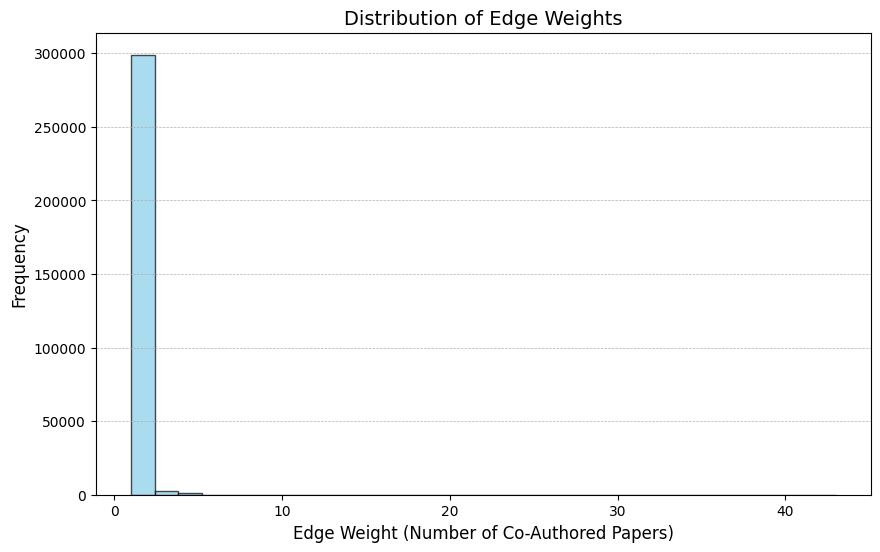

In [47]:
def plot_edge_weight_histogram(graph):
    """
    Plots a histogram of edge weights.

    Parameters:
        graph (networkx.Graph): The graph containing weighted edges.
    """
    # Extract edge weights
    edge_weights = [data["weight"] for _, _, data in graph.edges(data=True)]
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(edge_weights, bins=30, color="skyblue", edgecolor="black", alpha=0.7)
    plt.title("Distribution of Edge Weights", fontsize=14)
    plt.xlabel("Edge Weight (Number of Co-Authored Papers)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis="y", linestyle="--", linewidth=0.5)
    plt.show()

# Example usage
plot_edge_weight_histogram(researcher_graph)


#### Plot graph

In [31]:
def draw_researcher_graph(graph):
    """
    Draws the co-authorship graph using fa2_modified for layout, with edge width
    proportional to the weight.

    Parameters:
        graph (networkx.Graph): The co-authorship graph to visualize.
    """
    # Initialize ForceAtlas2
    forceatlas2 = ForceAtlas2(
        outboundAttractionDistribution=True,
        linLogMode=False,
        adjustSizes=False,
        edgeWeightInfluence=1.0,
        jitterTolerance=1.0,
        barnesHutOptimize=True,
        barnesHutTheta=1.2,
        scalingRatio=2.0,
        strongGravityMode=False,
        gravity=1.0,
        verbose=True
    )
    
    # Generate positions using ForceAtlas2
    positions = forceatlas2.forceatlas2_networkx_layout(graph, iterations=2000)
    
    # Normalize edge weights for visualization
    max_weight = max(nx.get_edge_attributes(graph, "weight").values())
    edge_widths = [graph[u][v]["weight"] / max_weight * 5 for u, v in graph.edges()]
    
    # Draw the graph
    plt.figure(figsize=(12, 12))
    nx.draw(
        graph,
        pos=positions,
        with_labels=False,
        node_size=50,
        edge_color="gray",
        width=edge_widths,
        alpha=0.7
    )
    
    # Draw node labels for largest nodes
    top_nodes = sorted(graph.degree, key=lambda x: x[1], reverse=True)[:10]
    nx.draw_networkx_labels(
        graph,
        pos=positions,
        labels={node: node for node, _ in top_nodes},
        font_size=8,
        font_color="red"
    )
    
    plt.title("Researcher Co-Authorship Network", fontsize=16)
    plt.axis("off")
    plt.show()

In [ ]:
# Draw the graph
draw_researcher_graph(researcher_graph)